In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import io
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import display
import ipywidgets as widgets

In [ ]:
!pip install -q kaggle

In [ ]:
# make kaggle directory
!mkdir ~/.kaggle

# move kaggle.json to hidden kaggle folder
!cp kaggle.json ~/.kaggle/

# change permissions on file
!chmod 600 ~/.kaggle/kaggle.json

# download zipped data
!kaggle datasets download -d datamunge/sign-language-mnist

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
 91% 57.0M/62.6M [00:00<00:00, 67.8MB/s]
100% 62.6M/62.6M [00:01<00:00, 64.9MB/s]


In [ ]:
!unzip sign-language-mnist.zip -d /content/sign-language-mnist

Archive:  sign-language-mnist.zip
  inflating: /content/sign-language-mnist/amer_sign2.png  
  inflating: /content/sign-language-mnist/amer_sign3.png  
  inflating: /content/sign-language-mnist/american_sign_language.PNG  
  inflating: /content/sign-language-mnist/sign_mnist_test.csv  
  inflating: /content/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv  
  inflating: /content/sign-language-mnist/sign_mnist_train.csv  
  inflating: /content/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv  


In [ ]:
train = pd.read_csv('/content/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
test = pd.read_csv('/content/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


One-hot encoded label: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


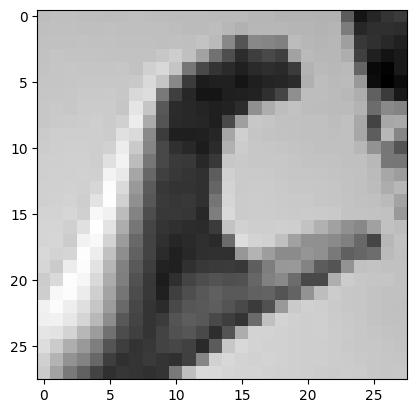

In [ ]:
# Separate labels and features
labels = train['label'].values
train.drop('label', axis=1, inplace=True)

# Convert image data
images = train.values
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array([i.flatten() for i in images])

# Normalize pixel values
images = images.astype('float32') / 255.0

# One-hot encode the labels
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)

# Display an example
index = 2
print("One-hot encoded label:", labels[index])
plt.imshow(images[index].reshape(28,28), cmap='gray')
plt.show()

In [ ]:
# Define the model architecture
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(24, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [ ]:
# Define a checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Fit the model on the training data
history = model.fit(images.reshape(-1, 28, 28, 1), labels, epochs=10, validation_split=0.2, callbacks=[checkpoint])


Epoch 1/10
687/687 [==============================] - 30s 40ms/step - loss: 1.6523 - accuracy: 0.4771 - val_loss: 0.3900 - val_accuracy: 0.8871
Epoch 2/10
  5/687 [..............................] - ETA: 19s - loss: 0.7331 - accuracy: 0.7750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


687/687 [==============================] - 24s 35ms/step - loss: 0.4384 - accuracy: 0.8508 - val_loss: 0.0776 - val_accuracy: 0.9794
Epoch 3/10
687/687 [==============================] - 27s 40ms/step - loss: 0.1904 - accuracy: 0.9338 - val_loss: 0.0215 - val_accuracy: 0.9936
Epoch 4/10
687/687 [==============================] - 28s 41ms/step - loss: 0.1061 - accuracy: 0.9655 - val_loss: 0.0074 - val_accuracy: 0.9993
Epoch 5/10
687/687 [==============================] - 28s 40ms/step - loss: 0.0746 - accuracy: 0.9750 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 6/10
687/687 [==============================] - 25s 36ms/step - loss: 0.0622 - accuracy: 0.9782 - val_loss: 0.0012 - val_accuracy: 0.9998
Epoch 7/10
687/687 [==============================] - 27s 39ms/step - loss: 0.0508 - accuracy: 0.9827 - val_loss: 7.2380e-04 - val_accuracy: 1.0000
Epoch 8/10
687/687 [==============================] - 29s 43ms/step - loss: 0.0423 - accuracy: 0.9851 - val_loss: 5.0477e-04 - val_accuracy: 1.

In [ ]:
# Separate labels and features for test data
test_labels = test['label'].values
test.drop('label', axis=1, inplace=True)

# Convert and reshape image data
test_images = test.values
test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
test_images = test_images.astype('float32') / 255.0

# One-hot encode the labels if your model's output layer and loss function require it
test_labels = label_binarizer.transform(test_labels)


In [ ]:
# Load the best model saved during training
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


225/225 [==============================] - 4s 16ms/step - loss: 0.2413 - accuracy: 0.9399
Test Loss: 0.2413056492805481
Test Accuracy: 0.9399051666259766


In [ ]:
def label_to_letter(label):
    if label >= 9:
        return chr(label + 66)
    else:
        return chr(label + 65)


print(label_to_letter(0))
print(label_to_letter(23))

A
Y


In [ ]:
import io
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import display
import ipywidgets as widgets

def predict_sign_language(img_data):
    try:
        # Load image from upload
        img = Image.open(io.BytesIO(img_data))
        img = img.convert('L')  # Convert to grayscale
        img = img.resize((28, 28))  # Resize to the same size as training data

        # Preprocess the image
        img_array = np.array(img)
        img_array = img_array.astype('float32') / 255.0
        img_array = img_array.reshape(1, 28, 28, 1)  # Reshape for the model

        # Predict the class
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)
        predicted_letter = label_to_letter(predicted_class[0])

        # Display the uploaded image
        display(img)
        print(f'Predicted Sign Language Letter: {predicted_letter}')
    except Exception as e:
        print(f"Error processing image: {str(e)}")


In [ ]:
# Create the upload button
upload_button = widgets.FileUpload(
    accept='image/*',  # Accept all image types
    multiple=False,    # Allow only single file uploads
    description='Upload Image'
)

# Display the upload button and output
output = widgets.Output()

def on_upload_change(change):
    output.clear_output()
    if upload_button.data:
        img_data = upload_button.data[-1]  # Get the most recent upload
        with output:
            predict_sign_language(img_data)

upload_button.observe(on_upload_change, names='data')

display(upload_button, output)

In [ ]:
model = load_model('path_to_your_model.h5')

cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if ret:
        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Resize and reshape the frame for prediction
        resized = cv2.resize(gray, (28, 28), interpolation=cv2.INTER_AREA)
        normalized = resized / 255.0
        reshaped = np.reshape(normalized, (1, 28, 28, 1))

        # Predict the gesture
        prediction = model.predict(reshaped)
        predicted_class = np.argmax(prediction, axis=1)
        predicted_letter = chr(predicted_class[0] + ord('A'))

        # Display the resulting frame with prediction
        cv2.putText(frame, f'Predicted Letter: {predicted_letter}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
        break

# When everything is done, release the capture
cap.release()
cv2.destroyAllWindows()
